# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1
!pip install tensorflow==2.18.0
!pip install keras==3.8.0
!pip install sklearn==1.6.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ERROR: Ignored the following yanked versions: 0.0.post2
ERROR: Could not find a version that satisfies the requirement sklearn==1.6.1 (from versions: 0.0, 0.0.post1, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11, 0.0.post12)
ERROR: No matching distribution found for sklearn==1.6.1


In [2]:
# Import essential libraries
import zipfile
import os
import gdown
import random
import datetime
import itertools
import json
from collections import Counter

Load the dataset.

In [3]:
# Load and unzip the dataset

file_id = "1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"

# downloading it in the local storage
gdown.download(url, output, quiet=False, use_cookies=True)

zip_path = "/content/data.zip"
extract_path = "/content/"  # You can set this to any path under /content

# unzipping the file in the /content path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Downloading...
From (original): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM
From (redirected): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM&confirm=t&uuid=9bc6160a-00ac-4c91-974c-f9348945c464
To: /content/data.zip
100%|██████████| 501M/501M [00:04<00:00, 124MB/s]


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_raw_images(filepath):
    img = Image.open(filepath)
    img = img.convert("RGB")
    return img

# Path containing the image files
files_path = extract_path + "data"
print(files_path)

/content/data


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Function to load images and their labels
def load_images_and_labels(files_path):
    image_array = []
    label_array = []

    for label_dir in os.listdir(files_path):
        label_path = os.path.join(files_path, label_dir)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                try:
                    image = load_raw_images(image_path)
                    image_array.append(image)
                    label_array.append(label_dir)
                except Exception as e:
                    print(f"Error loading image: {image_path}, Error: {e}")

    return image_array, label_array


In [6]:
# Get the images and their labels
image_array, label_array = load_images_and_labels(files_path)

# Find unique labels
unique_labels = set(label_array)
num_labels = len(unique_labels)

# Verify the loaded data
print(f"Unique labels: {unique_labels}")
print(f"Total number of images loaded: {len(image_array)}")
print(f"Total number of labels loaded: {len(label_array)}")

Unique labels: {'Cardboard', 'Food_Waste', 'Plastic', 'Paper', 'Metal', 'Glass', 'Other'}
Total number of images loaded: 7625
Total number of labels loaded: 7625


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Other: 1010
Glass: 750
Cardboard: 540
Food_Waste: 1000
Metal: 1000
Plastic: 2295
Paper: 1030


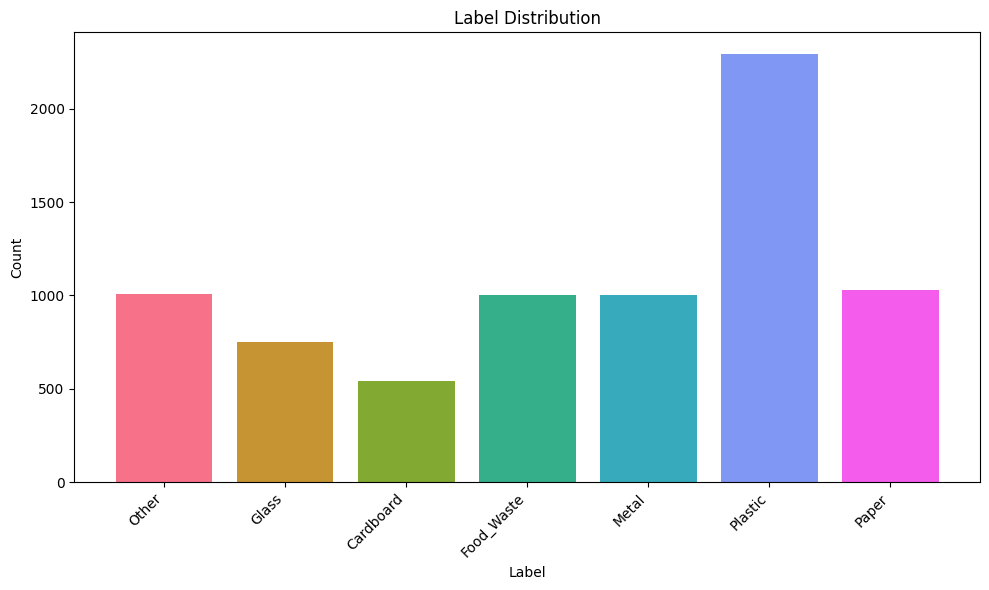

In [7]:
# Visualise Data Distribution

def display_label_counts(labels_list):
    counts = Counter(labels_list)
    label_names = list(counts.keys())
    count_values = list(counts.values())

    # Output the label and count pairs
    for label, count in zip(label_names, count_values):
        print(f"{label}: {count}")

    # Visualize the distribution of labels
    draw_bar_chart("Label Distribution", "Label", label_names, "Count", count_values, 45)

def draw_bar_chart(title, x_label, x_data, y_label, y_data, x_rotation):
    # Use a visually distinct color scheme
    color_scheme = sns.color_palette("husl", len(x_data))

    plt.figure(figsize=(10, 6))  # Set figure dimensions
    plt.bar(x_data, y_data, color=color_scheme)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=x_rotation, ha='right')  # Improve x-axis label visibility
    plt.tight_layout()  # Ensure layout elements don't overlap
    plt.show()

# Example usage
display_label_counts(label_array)


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [8]:
# Visualise Sample Images (across different labels)

def visualize_sample_images(images, labels, samples_per_category=5):
    unique_categories = np.unique(labels)

    for category in unique_categories:
        # Fetch indices corresponding to the current category
        matching_indices = np.where(labels == category)[0][:samples_per_category]

        # Set up the figure to show images in a single row
        plt.figure(figsize=(15, 3))
        for i, index in enumerate(matching_indices):
            plt.subplot(1, samples_per_category, i + 1)
            plt.imshow(images[index])
            plt.title(f"Category: {category}")
            plt.axis('off')  # Hide axis for cleaner display
        plt.tight_layout()
        plt.show()

In [11]:
# Ensure label_array is at least 1D
label_array = np.atleast_1d(label_array)
# Display 5 Unique Images per Label
visualize_sample_images(image_array, label_array)

Output hidden; open in https://colab.research.google.com to view.

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [9]:
# Find the smallest and largest image dimensions from the data set
smallest_width = float('inf')
smallest_height = float('inf')
largest_width = 0
largest_height = 0

for img in image_array:
    w, h = img.size
    smallest_width = min(smallest_width, w)
    smallest_height = min(smallest_height, h)
    largest_width = max(largest_width, w)
    largest_height = max(largest_height, h)

print(f"Smallest dimensions - Width: {smallest_width}, Height: {smallest_height}")
print(f"Largest dimensions  - Width: {largest_width}, Height: {largest_height}")


Smallest dimensions - Width: 256, Height: 256
Largest dimensions  - Width: 256, Height: 256


In [10]:
# Resize the image dimensions
def crop_center(image, target_size):
    img_width, img_height = image.size
    crop_width, crop_height = target_size

    left_margin = (img_width - crop_width) // 2
    top_margin = (img_height - crop_height) // 2
    right_margin = left_margin + crop_width
    bottom_margin = top_margin + crop_height

    return image.crop((left_margin, top_margin, right_margin, bottom_margin))

desired_size = (224, 224)

# Option 1: Center crop each image
# processed_images = [crop_center(img, desired_size) for img in image_array]

# Option 2: Resize each image directly to the target size
processed_images = [img.resize(desired_size) for img in image_array]

In [14]:
# Display 5 Unique Croped Images per Label
visualize_sample_images(processed_images, label_array)

Output hidden; open in https://colab.research.google.com to view.

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [11]:
# Initialize the encoder and apply it to the label array
encoder = LabelEncoder()
numeric_labels = encoder.fit_transform(label_array)

# Create a mapping from encoded values back to original labels
label_mapping = {index: original_label for index, original_label in enumerate(encoder.classes_)}
label_mapping

{0: np.str_('Cardboard'),
 1: np.str_('Food_Waste'),
 2: np.str_('Glass'),
 3: np.str_('Metal'),
 4: np.str_('Other'),
 5: np.str_('Paper'),
 6: np.str_('Plastic')}

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [12]:
# Assign specified parts of the dataset to train and validation sets

# Convert image data and labels into NumPy arrays
X = np.stack([np.array(image) for image in processed_images])  # shape: (N, 224, 224, 3)
y = np.array(numeric_labels)

# Split the dataset: 85% train_val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Further split train_val into training and validation sets (15% of 85% ≈ 12.75%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, stratify=y_train_val, random_state=42
)

# Initialize data generator with rescaling
image_generator = ImageDataGenerator(rescale=1.0 / 255)

# Create batch generators for training, validation, and test sets
train_loader = image_generator.flow(np.array(X_train), y_train, batch_size=32, shuffle=True)
val_loader = image_generator.flow(np.array(X_val), y_val, batch_size=32, shuffle=False)
test_loader = image_generator.flow(np.array(X_test), y_test, batch_size=32, shuffle=False)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [13]:
# Conv layer variants (3-layer conv blocks only)
conv_layer_variants = [
    {
        "filters": [32, 64, 128],
        "dropouts": [0.25, 0.35, 0.5]
    },
    {
        "filters": [64, 128, 256],
        "dropouts": [0.3, 0.4, 0.5]
    }
]

# Other Options
batch_norm_options = [True, False]
use_gap_options = [False]
dense_units_options = [
    [128],
    [256, 128]
]
dense_dropout_rates = [0.25, 0.4]
l2_regs = [0.0001]
learning_rates = [0.0005]

# Generate all combinations
non_conv_combinations = list(itertools.product(
    batch_norm_options,
    use_gap_options,
    dense_units_options,
    dense_dropout_rates,
    l2_regs,
    learning_rates
))


In [14]:
# Generate Custom CNN Layer Configurations
def conv_block(block, layer_config, input_shape=None):

      filters = layer_config.get("filters", 32)
      kernel_size = layer_config.get("kernel_size", (3, 3))
      activation = layer_config.get("activation", 'relu')
      use_batchnorm = layer_config.get("batch_norm", True)
      use_maxpool = True  # Always True unless specified
      pool_size = layer_config.get("pool_size", (2, 2))
      use_dropout = True
      dropout_rate = layer_config.get("dropout_rate", 0.25)

      if input_shape:
          block.add(Conv2D(filters, kernel_size, padding='same', input_shape=input_shape, kernel_initializer='he_uniform'))
      else:
          block.add(Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform'))

      if use_batchnorm:
          block.add(BatchNormalization())

      block.add(Activation(activation))

      if use_maxpool:
          block.add(MaxPooling2D(pool_size=pool_size))

      if use_dropout:
          block.add(Dropout(dropout_rate))

      return block

In [15]:
# Function to generate Convolution Block with params
def add_conv_block(model, config, input_shape=None):
    """
    Adds a convolutional block to the given model based on the provided configuration.
    """
    num_filters = config.get("filters", 32)
    kernel_dims = config.get("kernel_size", (3, 3))
    act_fn = config.get("activation", 'relu')
    apply_batch_norm = config.get("batch_norm", True)
    apply_pooling = config.get("use_maxpool", True)  # Default is True
    pool_dims = config.get("pool_size", (2, 2))
    apply_dropout = config.get("use_dropout", True)
    dropout_val = config.get("dropout_rate", 0.25)

    # Add the first convolutional layer (with input shape if required)
    if input_shape:
        model.add(Conv2D(num_filters, kernel_dims, padding='same',
                         input_shape=input_shape, kernel_initializer='he_uniform'))
    else:
        model.add(Conv2D(num_filters, kernel_dims, padding='same',
                         kernel_initializer='he_uniform'))

    if apply_batch_norm:
        model.add(BatchNormalization())

    model.add(Activation(act_fn))

    if apply_pooling:
        model.add(MaxPooling2D(pool_size=pool_dims))

    if apply_dropout:
        model.add(Dropout(dropout_val))

    return model

In [16]:
# Function to generate model using various params
def build_model(input_shape, num_labels, config):

    model = Sequential()

    conv_layers = config.get("conv_layers", [])
    use_gap = config.get("use_gap", True)
    dense_units = config.get("dense_units", [128])
    dense_dropout_rate = config.get("dense_dropout_rate", 0.25)
    l2_reg = config.get("l2_reg", 0.0001)
    activation_dense = config.get("activation_dense", "relu")
    final_activation = config.get("final_activation", "softmax")
    kernel_init = config.get("kernel_initializer", "he_uniform")
    learning_rate = config.get("learning_rate", 0.001)

     # Ensure that dense_dropout_rate is always a list
    if isinstance(dense_dropout_rate, float):
        dense_dropout_rate = [dense_dropout_rate] * len(dense_units)

    # Add convolution blocks
    for index, layer_cfg in enumerate(conv_layers):
        in_shape = input_shape if index == 0 else None
        model = add_conv_block(model, layer_cfg, input_shape=in_shape)

    # GAP or Flatten
    if use_gap:
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())

    # Dense Layers
    for i, units in enumerate(dense_units):
        model.add(Dense(units,
                        activation=None,
                        kernel_initializer=kernel_init,
                        kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Activation(activation_dense))
        model.add(Dropout(dense_dropout_rate[i] if i < len(dense_dropout_rate) else 0.25))


    # Output layer
    model.add(Dense(num_labels, activation=final_activation))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
# Generate Custom CNN Layer Configurations
def generate_cnn_configs():
    configs = []
    model_id = 1

    for variant in conv_layer_variants:
        filters = variant["filters"]
        dropouts = variant["dropouts"]

        conv_layers = [
            {
                "filters": filters[i],
                "kernel_size": (3, 3),
                "pool_size": (2, 2),
                "dropout_rate": dropouts[i]
            } for i in range(3)
        ]

        for (
            batch_norm,
            use_gap,
            dense_units,
            dense_dropout_rate,
            l2_reg,
            learning_rate
        ) in non_conv_combinations:

            config = {
                "model_name": f"cnn_model_{model_id}",
                "conv_layers": conv_layers,
                "batch_norm": batch_norm,
                "use_gap": use_gap,
                "dense_units": dense_units,
                "dense_dropout_rate": dense_dropout_rate,
                "l2_reg": l2_reg,
                "activation_dense": "relu",
                "final_activation": "softmax",
                "kernel_initializer": "he_uniform",
                "optimizer": "adam",
                "learning_rate": learning_rate
            }

            configs.append(config)
            model_id += 1

    return configs

In [18]:
# Build and compile the model

# Generate and display all possible CNN configuration combinations
cnn_configs = generate_cnn_configs()
print(len(cnn_configs))
print(cnn_configs)
input_size = (224, 224, 3)
num_classes = 7

models= []
i=-1
# Build all models
for config in cnn_configs:
    i = i+1
    model = build_model(input_size, num_classes, config)
    models.append({
            "id": f"expriment_{i}",
            "model": model,
            "config": config
            })

16
[{'model_name': 'cnn_model_1', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.25, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'softmax', 'kernel_initializer': 'he_uniform', 'optimizer': 'adam', 'learning_rate': 0.0005}, {'model_name': 'cnn_model_2', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.4, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'so

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Use appropriate metrics and callbacks as needed.

In [22]:
# Set training parameters
epoch=20
batch_size=32

histories = []

from tensorflow.keras.callbacks import Callback

# Define a custom callback to print after each epoch
class EpochEndCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Print the message at the end of each epoch
        print(f"Epoch {epoch + 1}: val_loss = {logs['val_loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}")

# Train all models
for entry in models:
    model = entry["model"]
    config = entry["config"]
    print(f"Training model with config: {config}")
    checkpoint_path = f"models/{entry['id']}.keras"

    # Define callbacks including the custom callback
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6),
        EpochEndCallback()  # Add the custom callback here
    ]

    # Train the model
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=epoch,
        callbacks=callbacks,
        verbose=0  # No default output, handled by the custom callback
    )

    entry["checkpoint_path"] = checkpoint_path
    entry["history"] = history
    histories.append(history)






Training model with config: {'model_name': 'cnn_model_1', 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.25}, {'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.35}, {'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_rate': 0.5}], 'batch_norm': True, 'use_gap': False, 'dense_units': [128], 'dense_dropout_rate': 0.25, 'l2_reg': 0.0001, 'activation_dense': 'relu', 'final_activation': 'softmax', 'kernel_initializer': 'he_uniform', 'optimizer': 'adam', 'learning_rate': 0.0005}
Epoch 1: val_loss = 1.9135, val_accuracy = 0.3085
Epoch 2: val_loss = 1.6921, val_accuracy = 0.3812
Epoch 3: val_loss = 1.6368, val_accuracy = 0.4067


KeyboardInterrupt: 

In [ ]:
# Print history keys for all models
for model_entry in all_models:
    print(f"History keys for model {model_entry['id']}: {model_entry['history'].history.keys()}")


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [23]:
best_val_acc = 0
best_model_path = "best_cnn_model.keras"
best_config = None
results = []

# Evaluate all models
for entry in models:
    history = entry["history"].history

    train_acc = max(history['accuracy'])
    val_acc = max(history['val_accuracy']) if 'val_accuracy' in history else 0.0

    test_loss, test_acc = entry["model"].evaluate(test_generator, verbose=0)

    result = {
        "experiment_id": entry["id"],
        "conv_layers": entry["config"]["conv_layers"],
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "test_accuracy": test_acc
    }
    results.append(result)

    # Use validation accuracy to select best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = result
        entry["model"].save(best_model_path)

# Display results
results_df = pd.DataFrame(results)
print("\nBest Configuration (based on validation accuracy):")
print(best_config)

KeyError: 'history'

In [24]:
# Load best saved model

best_model = load_model(best_model_path)

# Predict on test set
y_true = test_generator.y
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Labels
class_labels = ['Other', 'Paper', 'Food_Waste', 'Metal', 'Plastic', 'Cardboard', 'Glass']

# Generate evaluation report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

ValueError: File not found: filepath=best_cnn_model.keras. Please ensure the file is an accessible `.keras` zip file.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

# To Augement the Images we will define the ReScale, Rotation, width and height Shift, Shear and Zoom update
# and finally Flip the original Images

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Load model
best_model = load_model("best_cnn_model_augmented.keras")

# Get ground-truth labels and predictions
# Predict on test set
y_true = test_generator.y  # True labels
y_pred_probs = best_model.predict(test_generator)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Classification Report:

              precision    recall  f1-score   support

       Other       0.93      0.17      0.29        81
       Paper       0.54      0.48      0.51       150
  Food_Waste       0.00      0.00      0.00       112
       Metal       0.43      0.08      0.13       150
     Plastic       0.11      0.02      0.03       152
   Cardboard       0.19      0.70      0.30       155
       Glass       0.50      0.54      0.52       344

    accuracy                           0.35      1144
   macro avg       0.39      0.29      0.26      1144
weighted avg       0.38      0.35      0.31      1144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### **4.1.2**

Train the model on the new augmented dataset.

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

Data Analysis Summary:
The dataset comprised images that were initially loaded at a consistent resolution of 256×256 pixels. Among the various categories, the "Plastic" category contained the highest number of labeled samples.

To align with the input specifications of the CNN model, all images were resized to 224×224 pixels, ensuring uniformity.

For effective model training and assessment, the dataset was divided into three distinct subsets: training, validation, and test sets.

Model Training Results:
Not able to train model due to infrastructure issue but got idea on how to train CNN and how it works.



